# COURSE: A deep understanding of deep learning
## SECTION: CNN milestone projects
### LECTURE: Project 4: Psychometric functions in CNNs
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Import and process the data

In [2]:
nImages = 2000
imgSize = 30

# initialize tensor containing images
images = torch.zeros(nImages,1,imgSize,imgSize)
labels = torch.zeros(nImages,1)

for i in range(nImages):

  # and add noise
  G  = np.random.randn(imgSize,imgSize)

  # add a random bar randomly
  i1 = np.random.choice(np.arange(2,28))
  i2 = np.random.choice(np.arange(2,6))
  if np.random.randn()>0:
    G[i1:i1+i2,] = 1 # horizontal
  else:
    G[:,i1:i1+i2] = 1 # vertical
    labels[i] = 1
  
  # add to the tensor
  images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)

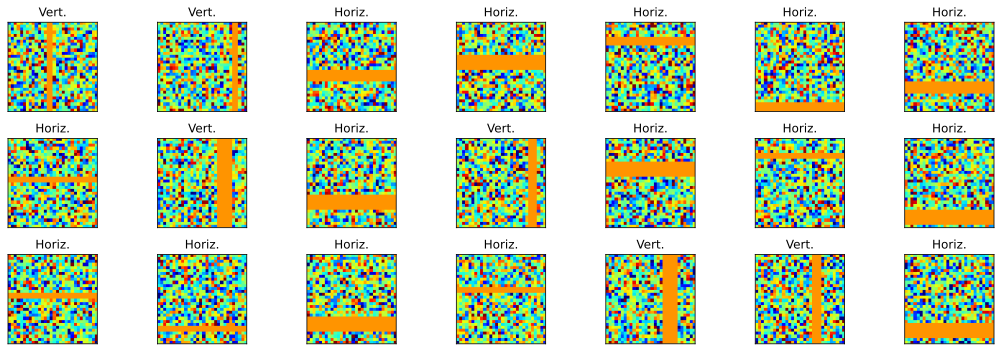

In [3]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(15,5))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(nImages)
  G = np.squeeze( images[whichpic,:,:] )
  ax.imshow(G,vmin=-2,vmax=2,cmap='jet',extent=[-4,4,-4,4],origin='upper')
  
  title = 'Horiz.' if labels[whichpic].item()==0 else 'Vert.'
  ax.set_title(title)
  ax.set_xticks([])
  ax.set_yticks([])

plt.tight_layout()
plt.show()

# Create train/test groups using DataLoader

In [4]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.1)

# convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [5]:
# check size (should be images X channels X width X height
train_loader.dataset.tensors[0].shape

torch.Size([1800, 1, 30, 30])

# Create the DL model

In [6]:
# create a class for the model
def createTheNet(printtoggle=False):

  class edgeNet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      ### convolution layers
      self.conv1 = nn.Conv2d( 1,5,kernel_size=3,stride=1,padding=1)
      # size: np.floor( (31+2*1-3)/1 )+1 = 31/2 = 15 (/2 b/c maxpool)

      self.conv2 = nn.Conv2d(5,10,kernel_size=3,stride=1,padding=1)
      # size: np.floor( (15+2*1-3)/1 )+1 = 15/2 = 7 (/2 b/c maxpool)

      # compute the number of units in FClayer (number of outputs of conv2)
      expectSize = np.floor( (7+2*0-1)/1 ) + 1 # fc1 layer has no padding or kernel, so set to 0/1
      expectSize = 10*int(expectSize**2)
      
      ### fully-connected layer
      self.fc1 = nn.Linear(expectSize,15)

      ### output layer
      self.out = nn.Linear(15,1)

      # toggle for printing out tensor sizes during forward prop
      self.print = printtoggle

    # forward pass
    def forward(self,x):
      
      print(f'Input: {x.shape}') if self.print else None

      # convolution -> maxpool -> relu
      x = F.relu(F.max_pool2d(self.conv1(x),2))
      print(f'Layer conv1: {x.shape}') if self.print else None

      # and again: convolution -> maxpool -> relu
      x = F.relu(F.max_pool2d(self.conv2(x),2))
      print(f'Layer conv2: {x.shape}') if self.print else None

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Vectorize: {x.shape}')
      
      # linear layers
      x = F.relu(self.fc1(x))
      if self.print: print(f'Layer fc1: {x.shape}')
      x = self.out(x)
      if self.print: print(f'Layer out: {x.shape}')

      return x
  
  # create the model instance
  net = edgeNet(printtoggle)
  
  # loss function
  lossfun = nn.BCEWithLogitsLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [7]:
# test the model with one batch
net,lossfun,optimizer = createTheNet(True)

X,y = next(iter(train_loader))
yHat = net(X)

# confirm shapes of prediction and actual
print(' ')
print(yHat.shape)
print(y.shape)

# finally, make sure the loss is computed
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

Input: torch.Size([32, 1, 30, 30])
Layer conv1: torch.Size([32, 5, 15, 15])
Layer conv2: torch.Size([32, 10, 7, 7])
Vectorize: torch.Size([32, 490])
Layer fc1: torch.Size([32, 15])
Layer out: torch.Size([32, 1])
 
torch.Size([32, 1])
torch.Size([32, 1])
 
Loss:
tensor(0.7045, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


# Create a function that trains the model

In [8]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 10
  
  # create a new model
  net,lossfun,optimizer = createTheNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # convert output to probability via sigmoid
      yy = torch.sigmoid(yHat)

      # then we compute whether p>.5
      acc = torch.mean(((yy>.5).float().detach() == y).float())
      batchAcc.append( 100*acc.item() )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
    
    # convert output to probability via sigmoid
    yy = torch.sigmoid(yHat)

    # then we compute whether p>.5
    acc = torch.mean(((yy>.5).float().detach() == y).float())
    testAcc.append( 100*acc.item() )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


# Run the model and show the results!

In [9]:
trainAcc,testAcc,losses,net = function2trainTheModel()

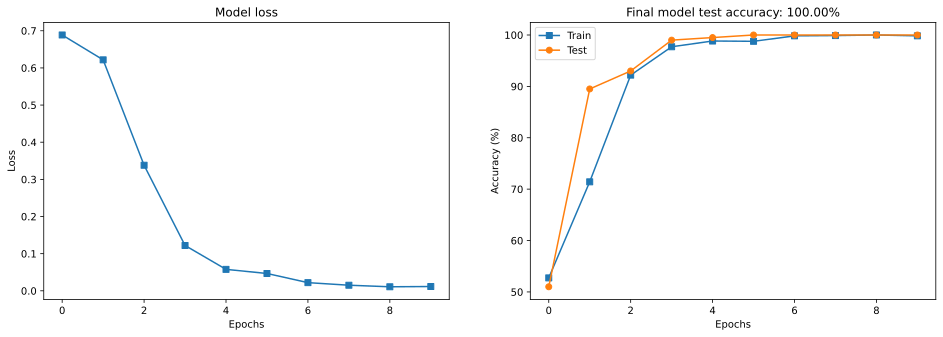

In [10]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

# Now for the test!

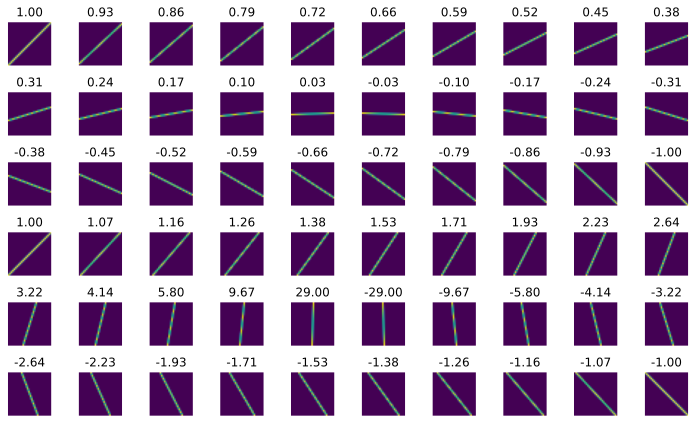

In [11]:
### create lines in images

from skimage.draw import line_aa

fig,ax = plt.subplots(6,10,figsize=(10,6))
imgs   = np.zeros((2*imgSize,1,imgSize,imgSize))
slopes = np.zeros(2*imgSize)

a = ax.flatten()
for i in range(imgSize):

  ### create lines with |slope|<1
  # point coords
  p1 = [0,i]
  p2 = [imgSize-p1[0]-1,imgSize-p1[1]-1]
  slopes[i] = (p2[1]-p1[1])/(p2[0]-p1[0]+1e-10)

  # create the lines
  rows,cols,val = line_aa(p1[1],p1[0],p2[1],p2[0]) #  y1,x1,y2,x2
  imgs[i,0,rows,cols] = val

  # plot
  a[i].imshow(imgs[i,0,:,:],origin='lower')
  a[i].set_title('%.2f'%slopes[i])
  a[i].axis('off')
  

  ### create lines with |slope|>1
  # point coords
  p1 = [i,0]
  p2 = [imgSize-p1[0]-1,imgSize-p1[1]-1]
  slopes[i+imgSize] = (p2[1]-p1[1])/(p2[0]-p1[0]+1e-10)

  # create the lines
  rows,cols,val = line_aa(p1[1],p1[0],p2[1],p2[0]) #  y1,x1,y2,x2
  imgs[i+imgSize,0,rows,cols] = val

  # plot
  a[i+imgSize].imshow(imgs[i+imgSize,0,:,:],origin='lower')
  a[i+imgSize].set_title('%.2f'%slopes[i+imgSize])
  a[i+imgSize].axis('off')

plt.tight_layout()
plt.show()

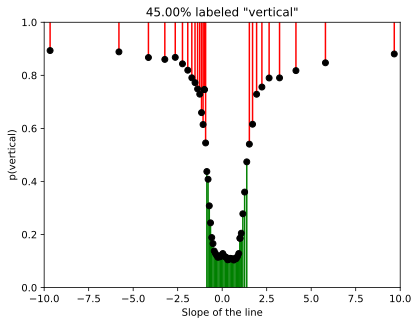

In [12]:
# run the images through the model

# randomly shuffle the images, just to be on the safe side...
# and also convert to tensor...
ridx = np.random.permutation(range(imgs.shape[0]))
imgT = torch.tensor(imgs[ridx,:,:,:].astype(np.float32))


# now generate the prediction (horizontal or vertical)
net.eval()
yHat = torch.sigmoid( net(imgT) ).detach()

# plot the results (make sure the slopes use the same randomization)
for i in range(len(slopes)):
  if yHat[i]>.5:
    plt.plot([slopes[ridx[i]],slopes[ridx[i]]],[1,yHat[i].item()],'r')
  else:
    plt.plot([slopes[ridx[i]],slopes[ridx[i]]],[0,yHat[i].item()],'g')

plt.plot(slopes[ridx],yHat,'ko')
plt.xlabel('Slope of the line')
plt.ylabel('p(vertical)')
plt.title('%.2f%% labeled "vertical"' %torch.mean(100*(yHat>.5).float()).item())
plt.ylim([0,1])
plt.xlim([-10,10]) # note: this actually clips two data points
plt.show()

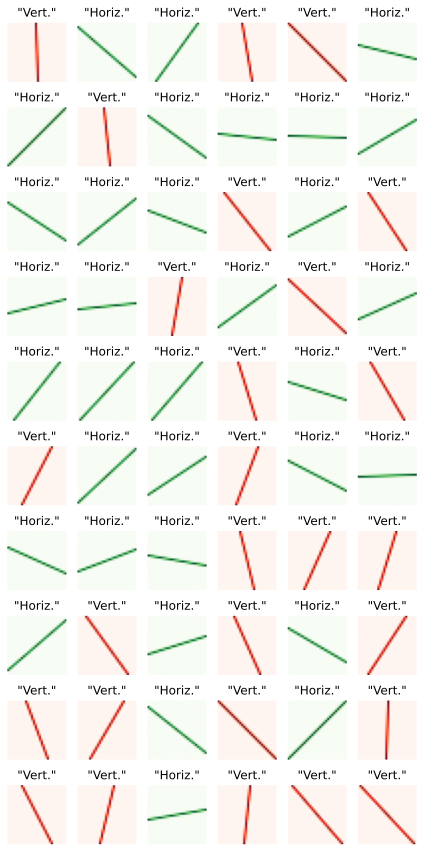

In [13]:
fig,ax = plt.subplots(10,6,figsize=(6,12))

for i,a in enumerate(ax.flatten()):
  
  # show the line-image (make sure to use the randomization index)
  if yHat[i]>.5:
    a.imshow(imgs[ridx[i],0,:,:],origin='lower',cmap='Reds')
  else:
    a.imshow(imgs[ridx[i],0,:,:],origin='lower',cmap='Greens')
  
  # and the title
  title = '"Vert."' if yHat[i].detach()>.5 else '"Horiz."'
  a.set_title(title)
  a.axis('off')

plt.tight_layout()
plt.show()